In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("21-housing.csv")

In [33]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [34]:
df.shape

(20640, 10)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [36]:
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


#Total Bedrooms have null values

In [37]:
df.fillna(df["total_bedrooms"].median(),inplace = True)

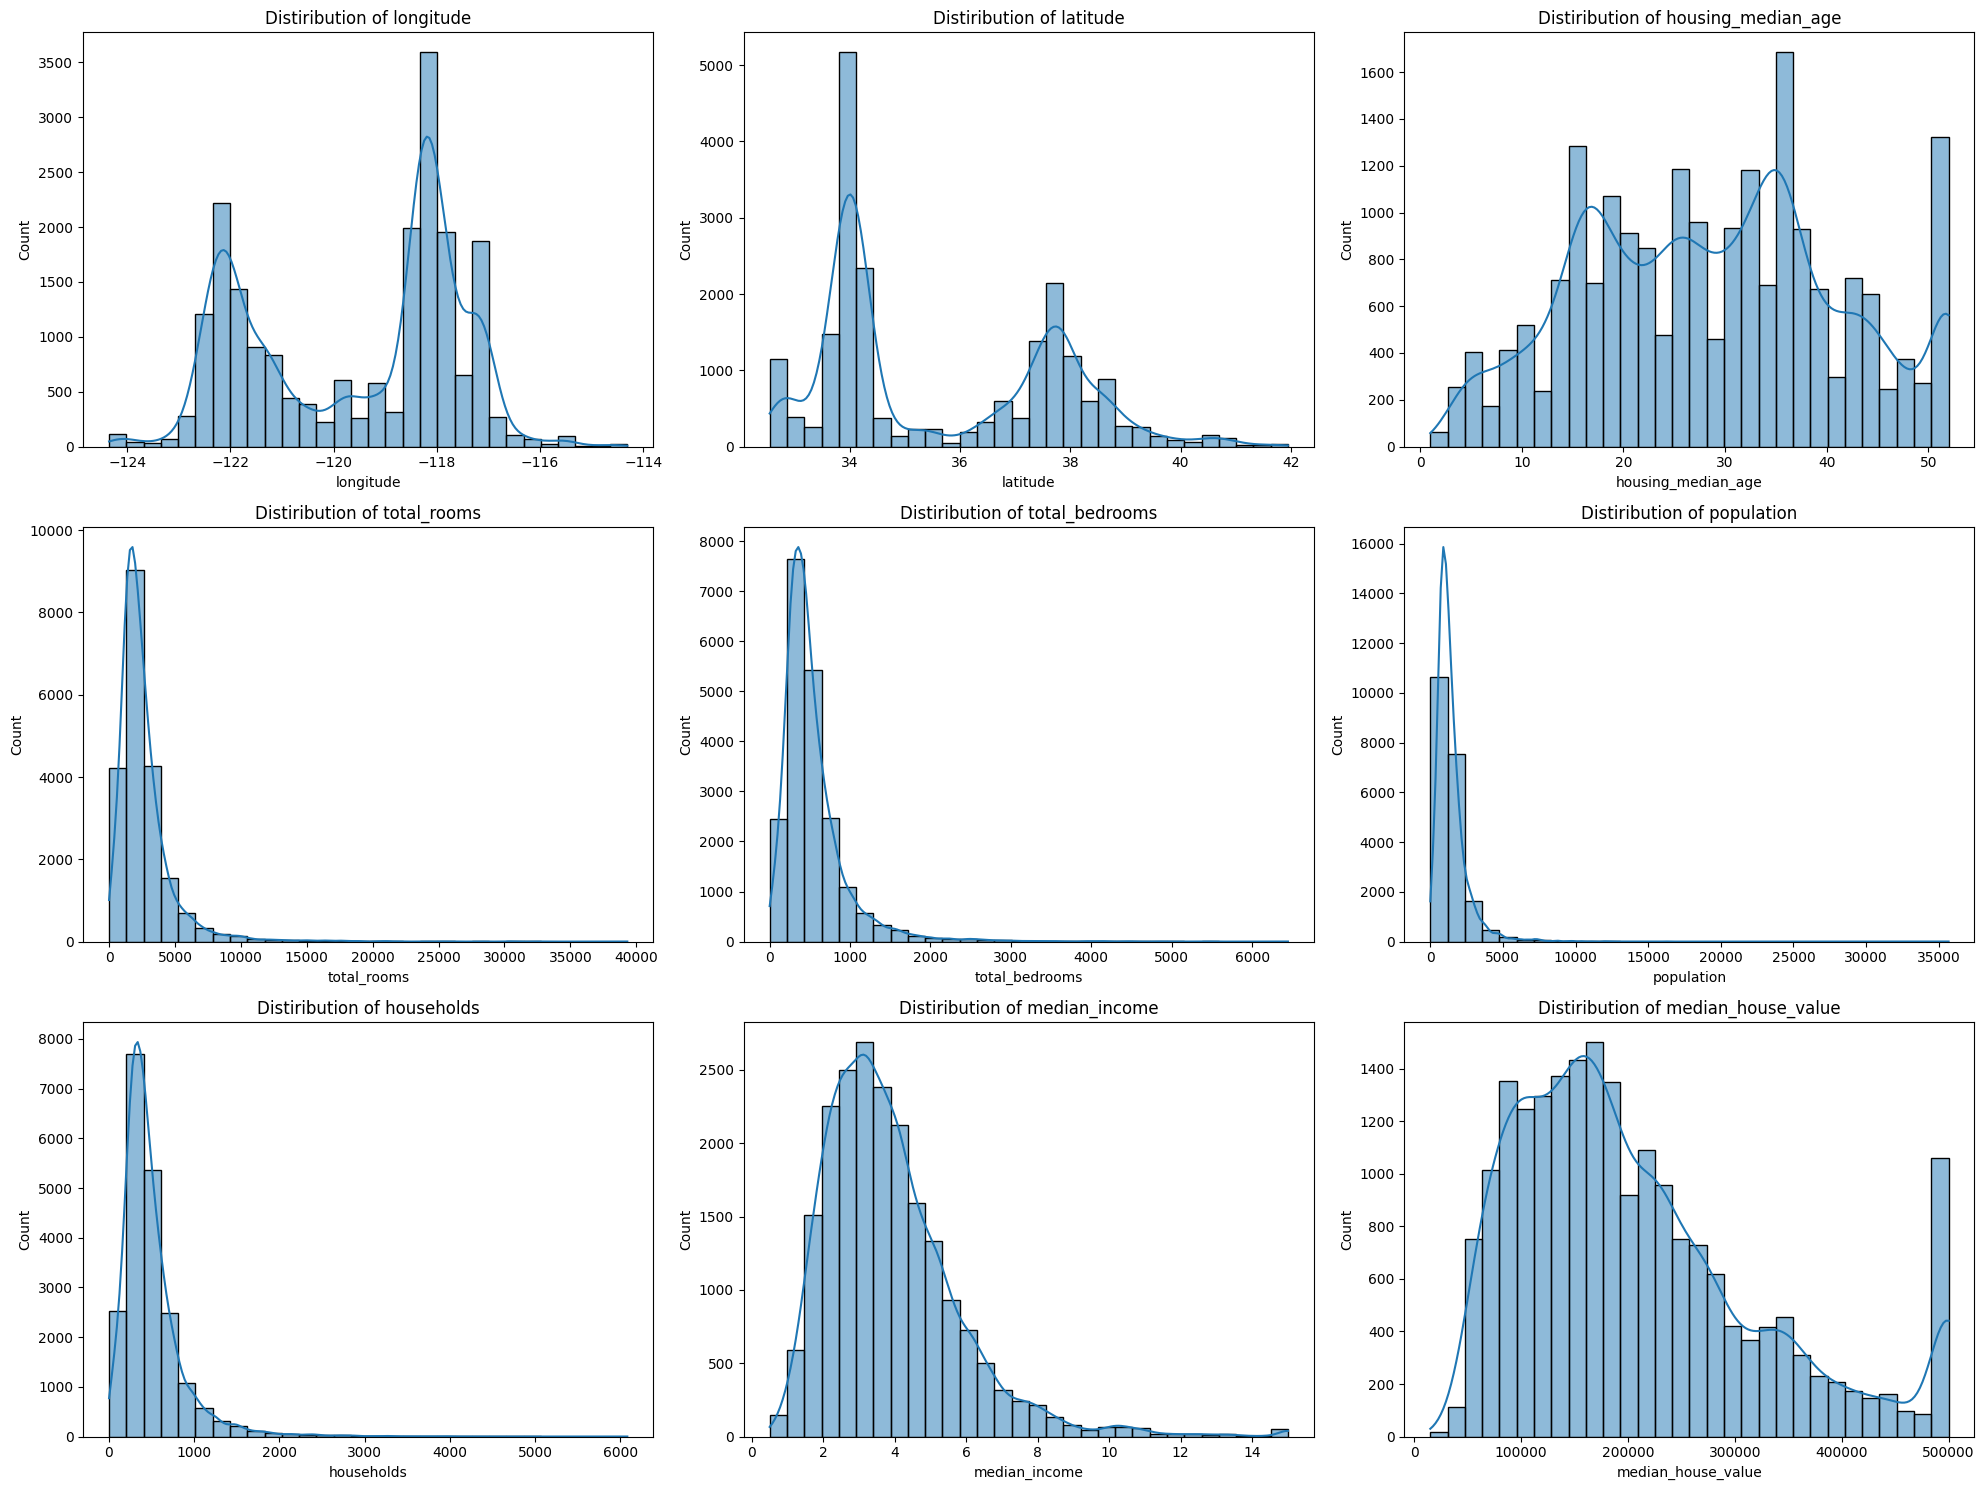

In [38]:
plt.figure(figsize = (20,15))
columns = list(df.drop("ocean_proximity",axis = 1).columns)
for i,col in enumerate(columns):
  plt.subplot(3,3,i+1)
  sns.histplot(data = df,kde = True,x = col,bins = 30)
  plt.title(f"Distiribution of {col}")
plt.tight_layout()
plt.show()

In [39]:
def find_outlier_iqr(df,threshold = 1.5):
  outlier_summary = {}

  numerical_colons = df.select_dtypes(include = ["float64","int64"]).columns
  for col in numerical_colons:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1

    lower_bound = Q1-IQR*threshold
    upper_bound = Q3+IQR*threshold
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_summary[col] = {
    "outliers_size" : outliers.shape[0],
    "lower_bound":lower_bound,
    "upper_bound":upper_bound
    }

  return pd.DataFrame(outlier_summary)


In [40]:
def remove_outlier_values(df, *cols, threshold=1.5):
    df_out = df.copy()
    for col in cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - IQR * threshold
        upper_bound = Q3 + IQR * threshold

        df_out = df_out[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df_out.copy()


In [41]:
a = find_outlier_iqr(df)
a.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [42]:
df2 = remove_outlier_values(df,"median_house_value")

In [43]:
df2.shape

(19569, 10)

In [44]:
df2 = pd.get_dummies(df2,dtype="int",drop_first=True)

In [45]:
X = df2.drop("median_house_value",axis = 1)
Y = df2["median_house_value"]

In [50]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from scipy.stats import boxcox,yeojohnson
from scipy.special import inv_boxcox

In [60]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state=42)
Pt = PowerTransformer(method='yeo-johnson')
x_train_transformed = pd.DataFrame(Pt.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test_transformed = pd.DataFrame(Pt.transform(x_test), columns=x_test.columns, index=x_test.index)

In [58]:
y_transformed,lambda_y= boxcox(y_train)

In [55]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [ ]:
models = {
    "Linear Regression" : LinearRegression(),
    "Lasso" : Lasso(),
    "Ridge" : Ridge(),
    "K Neighbors Regressor" : KNeighborsRegressor(),
    "Decision Tree" : DecisionTreeRegressor(),
    "Random Forest Regressor" : RandomForestRegressor(),
    "Adaboost Regressor" : AdaBoostRegressor(),
    "Gradient Boost Regressor" : GradientBoostingRegressor(),
    "XGBoost Regressor" : XGBRegressor()
}

In [57]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    print("Model performance for Training Set")
    print("Root Mean Squared Error: ", model_train_rmse)
    print("Mean Absolute Error: ", model_train_mae)
    print("R2 Score: ", model_train_r2)

    print("-----------------------------------")

    print("Model performance for Test Set")
    print("Root Mean Squared Error: ", model_test_rmse)
    print("Mean Absolute Error: ", model_test_mae)
    print("R2 Score: ", model_test_r2)

    print("-----------------------------------")
    print("\n")

Linear Regression
Model performance for Training Set
Root Mean Squared Error:  59257.65815818013
Mean Absolute Error:  43790.46479817129
R2 Score:  0.6129736472553484
-----------------------------------
Model performance for Test Set
Root Mean Squared Error:  59003.288635949844
Mean Absolute Error:  43498.67581874822
R2 Score:  0.6235605723025717
-----------------------------------


Lasso
Model performance for Training Set
Root Mean Squared Error:  59257.684856292544
Mean Absolute Error:  43791.01395439961
R2 Score:  0.612973298511381
-----------------------------------
Model performance for Test Set
Root Mean Squared Error:  59003.28635180396
Mean Absolute Error:  43498.80241058617
R2 Score:  0.6235606014481523
-----------------------------------


Ridge
Model performance for Training Set
Root Mean Squared Error:  59259.80294534743
Mean Absolute Error:  43795.112553214494
R2 Score:  0.612945630482401
-----------------------------------
Model performance for Test Set
Root Mean Squared

In [61]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train_transformed, y_transformed)

    y_train_pred = model.predict(x_train_transformed)
    y_test_pred = model.predict(x_test_transformed)

    y_train_pred_inv = inv_boxcox(y_train_pred, lambda_y)
    y_test_pred_inv = inv_boxcox(y_test_pred, lambda_y)

    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred_inv)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred_inv)

    print(list(models.keys())[i])
    print("Model performance for Training Set")
    print("Root Mean Squared Error: ", model_train_rmse)
    print("Mean Absolute Error: ", model_train_mae)
    print("R2 Score: ", model_train_r2)

    print("-----------------------------------")

    print("Model performance for Test Set")
    print("Root Mean Squared Error: ", model_test_rmse)
    print("Mean Absolute Error: ", model_test_mae)
    print("R2 Score: ", model_test_r2)

    print("-----------------------------------")
    print("\n")

Linear Regression
Model performance for Training Set
Root Mean Squared Error:  59207.67717657798
Mean Absolute Error:  42521.22460768165
R2 Score:  0.6136262481096131
-----------------------------------
Model performance for Test Set
Root Mean Squared Error:  57787.793177984895
Mean Absolute Error:  41789.43193587588
R2 Score:  0.6389104772083147
-----------------------------------


Lasso
Model performance for Training Set
Root Mean Squared Error:  66186.98852681994
Mean Absolute Error:  47873.63058342642
R2 Score:  0.5171671485605489
-----------------------------------
Model performance for Test Set
Root Mean Squared Error:  65548.86080095262
Mean Absolute Error:  47510.90269688821
R2 Score:  0.5354066765290242
-----------------------------------


Ridge
Model performance for Training Set
Root Mean Squared Error:  59208.715453816905
Mean Absolute Error:  42522.0286303436
R2 Score:  0.613612696941627
-----------------------------------
Model performance for Test Set
Root Mean Squared 